# Example:  Mauna Loa CO$_2$ continued

This GP example shows how to

- Fit fully Bayesian GPs with NUTS
- Model inputs whose exact locations are uncertain (uncertainty in 'x')
- Design a semiparametric Gaussian process model
- Build a changepoint covariance function / kernel
- Definine a custom mean and a custom covariance function

![Earth Systems Research Laboratory](https://www.esrl.noaa.gov/gmd/obop/mlo/pictures/sunsetmaunaloa1.jpg)


# Ice Core Data

The first data set we'll look at is CO2 measurments from ice core data.  This data goes back to the year 13 AD.  The data after the year 1958 is an average of ice core measurments and more accurate data taken from Mauna Loa.  **Disclaimer: I am not a climate scientist, I just think this is a cool dataset.  Some of my assumptions in this notebook might be incorrect! **

This data is less accurate than the Mauna Loa atmospheric CO2 measurments.  The dates of the ice core measurements have some uncertainty.  They may be accurate on a yearly level due to how the ice layers on it self every year, but the date isn't likely to be reliable as to the season when the measurment was taken.  Also, the CO2 level observed may be some sort of average of the overall yearly level.  As we saw in the previous example, there is a strong seasonal component in CO2 levels that won't be observable in this data set.

In PyMC3, we can easily include both errors in $y$ and errors in $x$.  To demonstrate this, we remove the latter part of the data (which are averaged with Mauna Loa readings) so we have only the ice core measurements.  We fit the Gaussian process model using the No-U-Turn MCMC sampler.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ice = pd.read_csv(pm.get_data("merged_ice_core_yearly.csv"), header=26)
ice.columns = ["year", "CO2"]
ice["CO2"] = ice["CO2"].astype(np.float)

#### DATA AFTER 1958 is an average of ice core and mauna loa data, so remove it
ice = ice[ice["year"] <= 1958]
print("Number of data points:", len(ice))

Number of data points: 111


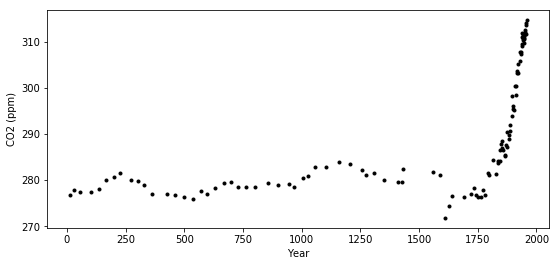

In [3]:
fig = plt.figure(figsize=(9,4))
ax = plt.gca()

ax.plot(ice.year.values, ice.CO2.values, '.k');
ax.set_xlabel("Year")
ax.set_ylabel("CO2 (ppm)");

The industrial revolution era occured around the years 1760 to 1840.  This point is clearly visible in the graph, where CO2 levels rise dramatically after being fairly stationary at around 280 ppm for over a thousand years.

## Uncertainty in 'x'

To model uncertainty in $x$, or time, we place a prior distribution over each of the observation dates.  So that the prior is standardized, we specifically use a PyMC3 random variable to model the difference between the date given in the data set, and it's error.  We assume that these differences are normal with mean zero, and standard deviation of 1 year.

For just the ice core data, the uncertainty in $x$ is not very important.  Later when we include the more accurate Mauna Loa measurments, allowing for this uncertainty will enable us to back-cast seasonal variation.

In [4]:
t = ice.year.values
y = ice.CO2.values

# normalize the CO2 readings prior to fitting the model 
y_mu, y_sd = np.mean(y), np.std(y)
y_n = (y - y_mu) / y_sd

# scale t to have units of centuries
t_n = t / 100

We use an informative prior on the lengthscale that places most of the mass between a few and 20 centuries.

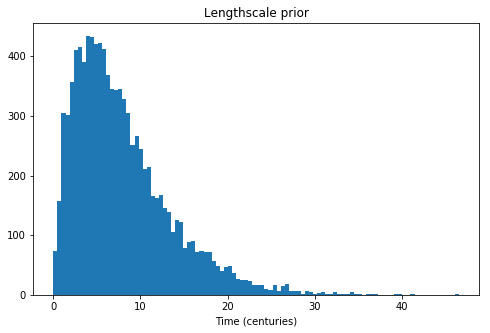

In [5]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.hist(pm.Gamma.dist(alpha=2, beta=0.25).random(size=10000), 100)
ax.set_xlabel("Time (centuries)")
ax.set_title("Lengthscale prior");

In [6]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sd=5)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=0.25)
    cov = η**2 * pm.gp.cov.Matern32(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
    
    # x location uncertainty (sd = 0.01 is a standard deviation of one year)
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.01, shape=len(t))
    t_uncert = t_n - t_diff
    
    # white noise variance
    σ = pm.HalfNormal("σ", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=t_uncert[:,None], y=y_n, noise=σ)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '17659' (I am process '3230')


Next we can sample with the NUTS MCMC algorithm.  We run two chains but set the number of cores to one, since the linear algebra libraries used internally by Theano are multicore.

In [7]:
with model:
    tr = pm.sample(500, chains=2, cores=1, nuts_kwargs={"target_accept":0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, t_diff, ℓ, η]
100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s]


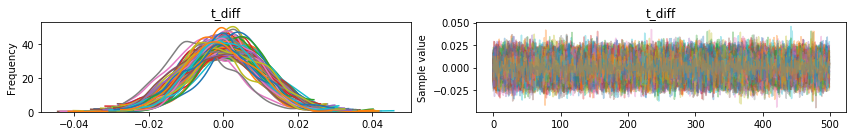

In [8]:
pm.traceplot(tr, varnames=["t_diff"]);

In the traceplot for `t_diff`, we can see that the posterior peaks for the different inputs haven't moved much, but the uncertainty in location is accounted for by the sampling.

The posterior distributions for the other unknown hyperparameters is below.

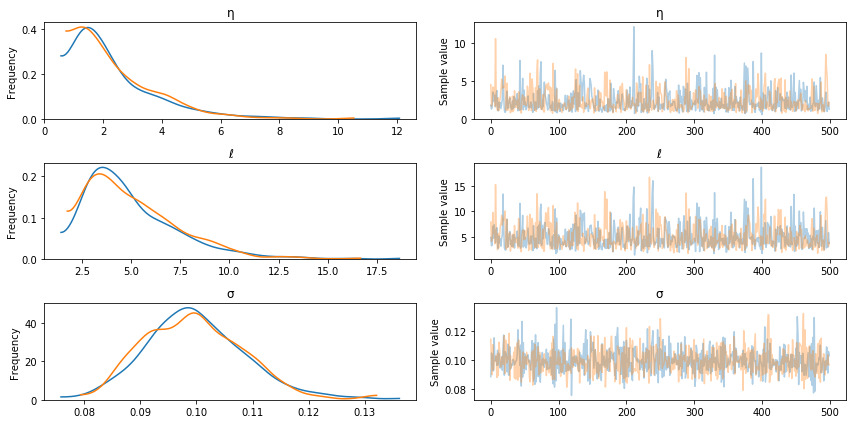

In [9]:
pm.traceplot(tr, varnames=["η", "ℓ", "σ"]);

### Predictions

In [10]:
tnew = np.linspace(-100, 2150, 2000)/100
with model:
    fnew = gp.conditional("fnew", Xnew=tnew[:,None])
    
with model:
    ppc = pm.sample_ppc(tr, samples=100, vars=[fnew])

100%|██████████| 100/100 [15:26<00:00,  9.26s/it]


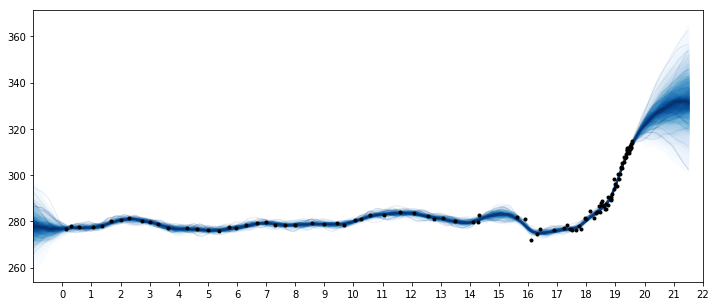

In [11]:
samples = y_sd * ppc["fnew"] + y_mu

fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tnew, plot_samples=True, palette="Blues")
ax.plot(t/100, y, "k.");
ax.set_xticks(np.arange(0,23));
ax.set_xlim([-1, 22]);

Two features are apparent in this plot.  One is the [little ice age](https://www.nature.com/articles/ngeo2769), whose effects on CO2 occurs from around 1600 to 1800.  The next is the industrial revolution, when people began releasing large amounts of CO2 into the atmosphere.  


## Semiparametric Gaussian process

The forecast past the latest data point in 1958 rises, then flattens, then dips back downwards.  Should we trust this forecast?  We know it hasn't been born out (see the previous notebook) as CO2 levels have continued to rise.   

We didn't specify a mean function in our model, so we've assumed that our GP has a mean of zero.  This means that
as we forecast into the future, the function will eventually return to zero.  Is this reasonable in this case?  There have been no global events that suggest that atmospheric CO2 will not continue on its current trend.  

### A linear model for changepoints

We adopt the formulation used by [Facebooks prophet](https://peerj.com/preprints/3190.pdf) time series model.  This is a linear peicewise function, where each segments endpoints are restricted to be connect to one another.  Some example functions are plotted below. 

In [12]:
def dm_changepoints(t, changepoints_t):
    A = np.zeros((len(t), len(changepoints_t)))
    for i, t_i in enumerate(changepoints_t):
        A[t >= t_i, i] = 1 
    return A

For later use, we reprogram this function using symbolic theano variables.  The code is a bit inscrutible, but it returns the same thing as `dm_changepoitns` while avoiding the use of a loop.

In [13]:
def dm_changepoints_theano(X, changepoints_t):
    return (0.5 * (1.0 + tt.sgn(tt.tile(X, (1,len(changepoints_t))) - changepoints_t)))

From looking at the graph, some possible locations for changepoints are at 1600, 1800 and maybe 1900.  These bookend the little ice age, the start of the industrial revolution, and the start of more modern industrial practices.

In [14]:
changepoints_t = np.array([16, 18, 19])

A = dm_changepoints(t_n, changepoints_t)

There are several parameters (which we will estimate), some test values and a plot of the resulting function is shown below

In [15]:
# base growth rate, or initial slopw
k = 0.0

# offset
m = 0.1

# slope parameters
delta = np.array([0.05, -0.1, 0.3])

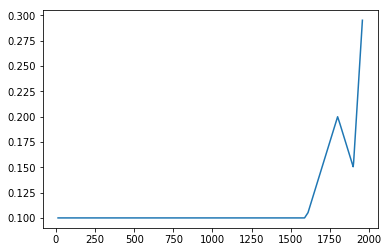

In [16]:
x = (k + np.dot(A, delta))*t_n + (m + np.dot(A, -changepoints_t * delta))
plt.plot(t, x);

### A custom changepoint mean function

We could encode this mean function directly, but if we wrap it inside of a `Mean` object, then it easier to use other Gaussian process functionality, like the `.conditional` and `.predict` methods.  Look here [for more information on custom mean and covariance functions](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html#Defining-a-custom-mean-function).  We only need to define `__init__` and `__call__` functions. 

In [17]:
class PeicewiseLinear(pm.gp.mean.Mean):
    def __init__(self, changepoints, k, m, delta):
        self.changepoints = changepoints
        self.k = k
        self.m = m
        self.delta = delta
    
    def __call__(self, X):
        # X are the x locations, or time points
        A = dm_changepoints_theano(X, self.changepoints)
        return (self.k + tt.dot(A, self.delta))*X.flatten() + (self.m + tt.dot(A, -self.changepoints * self.delta))

It is inefficient to recreate `A` every time the mean function is evaluated, but we'll need to do this when the number of inputs changes when making predictions.

### Semiparametric changepoint model

Next is the updated model with the changepoint mean function.  Like Prophet, we use a heavy tailed `Laplace` prior on the slope parameters.

In [18]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sd=5)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=0.25)
    cov = η**2 * pm.gp.cov.Matern32(1, ℓ)
    
    # peicewise linear mean function
    k = pm.Normal("k", mu=0, sd=2)
    m = pm.Normal("m", mu=0, sd=2)
    delta = pm.Laplace("delta", mu=0, b=1, shape=len(changepoints_t))
    mean = PeicewiseLinear(changepoints_t, k, m, delta)   

    # include mean function in GP constructor
    gp = pm.gp.Marginal(cov_func=cov, mean_func=mean)
    
    # x location uncertainty (sd = 0.01 is a standard deviation of one year)
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.01, shape=len(t))
    t_uncert = t_n - t_diff
    
    # white noise variance
    σ = pm.HalfNormal("σ", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=t_uncert[:,None], y=y_n, noise=σ)

In [19]:
with model:
    tr = pm.sample(500, chains=2, cores=1, nuts_kwargs={"target_accept":0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, t_diff, delta, m, k, ℓ, η]
100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


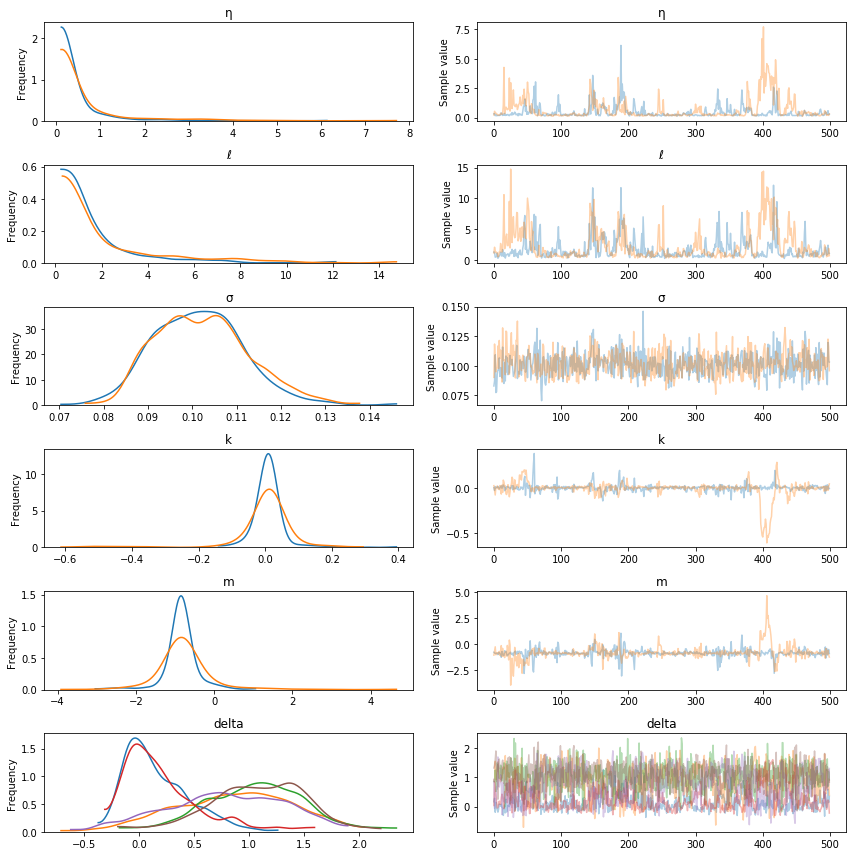

In [20]:
pm.traceplot(tr, varnames=["η", "ℓ", "σ", "k", "m", "delta"]);

### Predictions

In [21]:
tnew = np.linspace(-100, 2200, 2000)/100

with model:
    fnew = gp.conditional("fnew", Xnew=tnew[:,None])
    
with model:
    ppc = pm.sample_ppc(tr, samples=100, vars=[fnew])

100%|██████████| 100/100 [12:13<00:00,  7.33s/it]


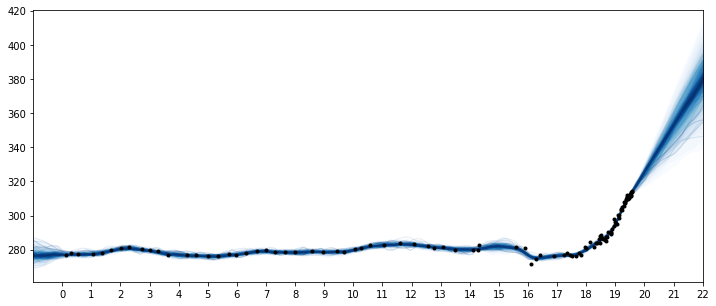

In [22]:
samples = y_sd * ppc["fnew"] + y_mu

fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tnew, plot_samples=True, palette="Blues")
ax.plot(t/100, y, "k.");
ax.set_xticks(np.arange(0,23));
ax.set_xlim([-1, 22]);

These results look better, but we had to choose exactly where the changepoints were.  Instead of using a changepoint in the mean function, we could also specify this same changepoint behavior in the form of a covariance function.  One benefit of the latter formulation is that the changepoint can be a more realistic smooth transition, instead of a discrete breakpoint.  In the next section, we'll look at how to do this.

# A custom changepoint covariance function

More complex covariance functions can be constructed by composing base covariance
functions in several ways.  For instance, two of the most commonly used operations are

- The sum of two covariance functions is a covariance function
- The product of two covariance functions is a covariance function

We can also construct a covariance function by scaling a base covariance function ($k_b$) by any arbitrary function,
$$ k(x, x) = s(x) k_{\mathrm{b}}(x, x') s(x') \,. $$
The scaling function can be parameterized by known parameters, or unknown parameters can be inferred.

### Heaviside step function

To specifically construct a covariance function that describes a changepoint, 
we could propose a scaling function $s(x)$ that specifies the region where the base covariance is active.   The simplest option is the step function,

$$ s(x;\, x_0) = 
\begin{cases} 
   0 & x \leq x_0 \\
   1 & x_0 < x
\end{cases} 
$$

which is parameterized by the changepoint $x_0$.  The covariance function $s(x; x_0) k_b(x, x') s(x'; x_0)$ is only active in the region $x \leq x_0$.  

The PyMC3 contains the `ScaledCov` covariance function.  As arguments, it takes a base
covariance, a scaling function, and the tuple of the arguments for the base covariance.  To construct this in PyMC3, we first define the scaling function:

In [23]:
def step_function(x, x0, greater=True):
    if greater:
        # s = 1 for x < x_0
        return 0.5 * (tt.sgn(x - x0) + 1.0)
    else:
        return 0.5 * (tt.sgn(x0 - x) + 1.0)

In [24]:
step_function(np.linspace(0, 10, 10), x0=5, greater=True).eval()

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

In [25]:
step_function(np.linspace(0, 10, 10), x0=5, greater=False).eval()

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

Then we can define the the following covariance function.  We compute it over $x \in (0, 100)$.  The base covariance has a lengthscale of 10, and $x_0 = 40$.  Since we are using a step function, it is "active" for $x < 40$.

In [26]:
cov = pm.gp.cov.ExpQuad(1, 10)
sc_cov = pm.gp.cov.ScaledCov(1, cov, step_function, (40, False))

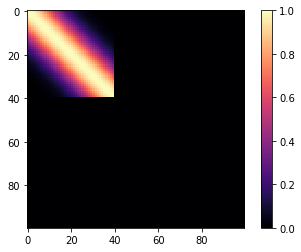

In [27]:
x = np.linspace(0, 100, 100)
K = sc_cov(x[:,None]).eval()
m=plt.imshow(K, cmap="magma"); plt.colorbar(m);

But his isn't a changepoint covariance function yet.  We can add two of these together.  For $x < 40$, Lets use a base covariance that is a `Matern32` with a lengthscale of 5 and an amplitude of 0.25.

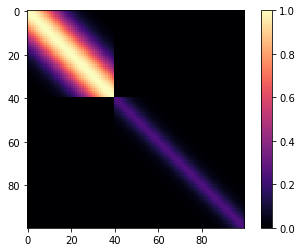

In [28]:
cov1 = pm.gp.cov.ExpQuad(1, 10)
sc_cov1 = pm.gp.cov.ScaledCov(1, cov1, step_function, (40, False))

cov2 = 0.25 * pm.gp.cov.Matern32(1, 5)
sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, step_function, (40, True))

sc_cov = sc_cov1 + sc_cov2

# plot over 0 < x < 100
x = np.linspace(0, 100, 100)
K = sc_cov(x[:,None]).eval()
m=plt.imshow(K, cmap="magma"); plt.colorbar(m);

What do samples from the Gaussian process prior with this covariance look like?

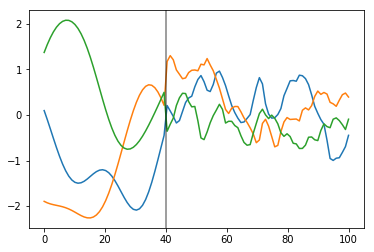

In [29]:
prior_samples = np.random.multivariate_normal(np.zeros(100), K, 3).T
plt.plot(x, prior_samples);
plt.axvline(x=40, color="k", alpha=0.5);

Before $x = 40$, the function is smooth and slowly changing.  After $x = 40$, the samples are less smooth and change quickly.

### A gradual change with a sigmoid function

Instead of a sharp cutoff, It is usually more realistic to have a smooth transition.  For this we can use the logistic function, shown below:

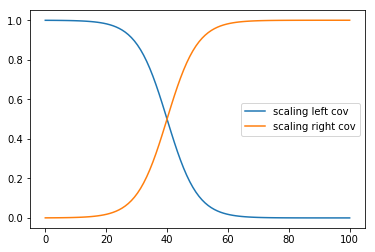

In [30]:
# a is the slope, b is the location

a = -0.2
b = 40
plt.plot(x, pm.math.invlogit(a*(x - b)).eval(), label="scaling left cov");

a = 0.2
b = 40
plt.plot(x, pm.math.invlogit(a*(x - b)).eval(), label="scaling right cov");
plt.legend();

In [31]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return pm.math.invlogit(a*(x - x0))

The same covariance function as before, but with a gradual changepoint is shown below.

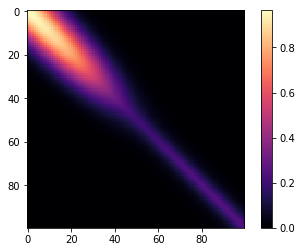

In [32]:
cov1 = pm.gp.cov.ExpQuad(1, 10)
sc_cov1 = pm.gp.cov.ScaledCov(1, cov1, logistic, (-0.1, 40))

cov2 = 0.25 * pm.gp.cov.Matern32(1, 5)
sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, logistic, (0.1, 40))

sc_cov = sc_cov1 + sc_cov2

# plot over 0 < x < 100
x = np.linspace(0, 100, 100)
K = sc_cov(x[:,None]).eval()
m=plt.imshow(K, cmap="magma"); plt.colorbar(m);

Below, you can see that the transition of the prior functions from one region to the next is more gradual,

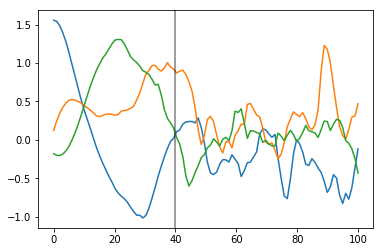

In [33]:
prior_samples = np.random.multivariate_normal(np.zeros(100), K, 3).T
plt.plot(x, prior_samples);
plt.axvline(x=40, color="k", alpha=0.5);

Lets try this model out instead of the semiparametric changepoint version.

### Changepoint covariance model

The features of this model are:

- One covariance for short term variation across all time points
- The parameter `x0` is the location of the industrial revolution.  It is given a prior that has most of its support between years 1760 and 1840, centered at 1800.
- We can easily use the parameter as the `shift` parameter in the 2nd degree `Polynomial` (quadratic) covariance, and as the location of the changepoint in the changepoint covariance.
- A changepoint covariance that is `ExpQuad` prior to the industrial revolution, and `ExpQuad + Polynomial(degree=2)` afterwards.
- We use the same scaling and lengthscale parameters for each of the two base covariances in the changepoint covariance.
- Still modeling uncertainty in `x` as before

In [34]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sd=5)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=0.1)
    
    # changepoint occurs near the year 1800, sometime between 1760, 1840
    x0 = pm.Normal("x0", mu=18, sd=0.1)
    # the change happens gradually
    a = pm.HalfNormal("a", sd=2)
    # a constant for the 
    c = pm.HalfNormal("c", sd=3)
    # quadratic polynomial scale
    ηq = pm.HalfNormal("ηq", sd=5)
    
    cov1 = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    cov2 = η**2 * pm.gp.cov.ExpQuad(1, ℓ) + ηq**2 * pm.gp.cov.Polynomial(1, x0, 2, c)
   
    # construct changepoint cov
    sc_cov1 = pm.gp.cov.ScaledCov(1, cov1, logistic, (-a, x0))
    sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, logistic, ( a, x0))
    cov_c = sc_cov1 + sc_cov2
    
    # short term variation
    ηs = pm.HalfNormal("ηs", sd=5)
    ℓs = pm.Gamma("ℓs", alpha=2, beta=1)
    cov_s = ηs**2 * pm.gp.cov.Matern52(1, ℓs)
    
    gp = pm.gp.Marginal(cov_func=cov_s + cov_c)

    # x location uncertainty (sd = 0.01 is a standard deviation of one year)
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.01, shape=len(t))
    t_uncert = t_n - t_diff
    
    # white noise variance
    σ = pm.HalfNormal("σ", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=t_uncert[:,None], y=y_n, noise=σ)

In [35]:
with model:
    tr = pm.sample(500, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, t_diff, ℓs, ηs, ηq, c, a, x0, ℓ, η]
100%|██████████| 1000/1000 [02:02<00:00,  8.18it/s]
The acceptance probability does not match the target. It is 0.8988327928717826, but should be close to 0.8. Try to increase the number of tuning steps.


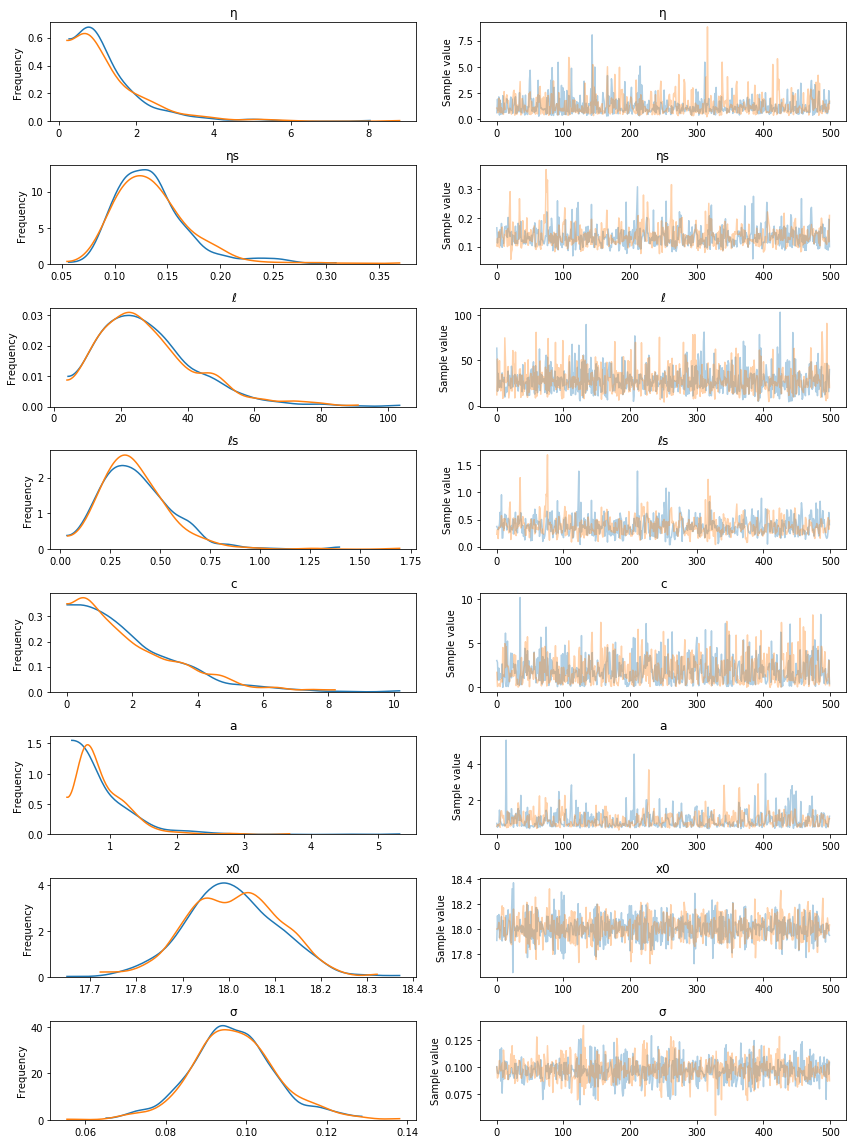

In [36]:
pm.traceplot(tr, varnames=["η", "ηs", "ℓ", "ℓs", "c", "a", "x0", "σ"]);

### Predictions

In [37]:
tnew = np.linspace(-100, 2300, 2200)/100

with model:
    fnew = gp.conditional("fnew", Xnew=tnew[:,None])
    
with model:
    ppc = pm.sample_ppc(tr, samples=100, vars=[fnew])

100%|██████████| 100/100 [17:02<00:00, 10.23s/it]


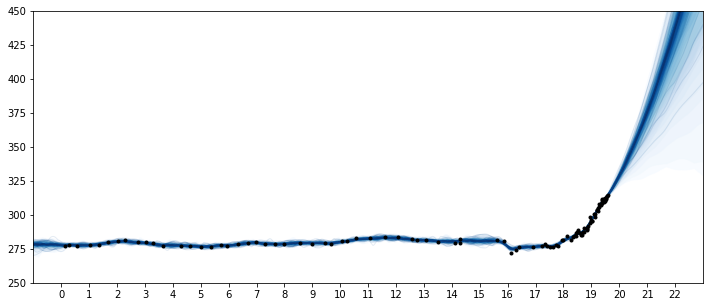

In [38]:
samples = y_sd * ppc["fnew"] + y_mu

fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tnew, plot_samples=True, palette="Blues")
ax.plot(t/100, y, "k.");
ax.set_xticks(np.arange(0,23));
ax.set_xlim([-1, 23]);
ax.set_ylim([250, 450]);

The predictions for this model look much more realistic.  The product of a 2nd degree polynomial with an `ExpQuad` looks like a good model to forecast with.  It allows for
the amount of CO2 to increase in a not-exactly-linear fashion.  We can see from the predictions that 

- The amount of CO2 could increase at a faster rate
- The amount of CO2 should increase more or less linearly
- It is possible for the CO2 to start to decrease

## Incorporating Atmospheric CO2 measurements

Next, we incorporate the CO2 measurements from the Mauna Loa observatory.  These data points were taken monthly from atmospheric levels.  Unlike the ice core data, there is no uncertainty in these measurements.  While modeling both of these data sets together, the value of including the uncertainty in the ice core measurement time will be more apparent.

First let's load in the data, and then plot it alongside the ice core data.

In [41]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    date = pd.to_datetime(date)
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [42]:
airdata = pd.read_csv(pm.get_data("monthly_in_situ_co2_mlo.csv"), header=56)
 
# - replace -99.99 with NaN
airdata.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = ["year", "month", "--", "--", "CO2", "seasonaly_adjusted", "fit",
        "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"]
airdata.columns = cols
cols.remove("--"); cols.remove("--")
airdata = airdata[cols]

# drop rows with nan
airdata.dropna(inplace=True)

# fix time index
airdata["day"] = 15
airdata.index = pd.to_datetime(airdata[["year", "month", "day"]])
airdata["year"] = [toYearFraction(date) for date in airdata.index.values]
cols.remove("month")
airdata = airdata[cols]

air = airdata[["year", "CO2"]]
air.head(5)

,year,CO2
1958-03-15,1958.200000,315.69
1958-04-15,1958.284932,317.46
1958-05-15,1958.367009,317.50
1958-07-15,1958.534132,315.86
1958-08-15,1958.619064,314.93


Like was done in the first notebook, we reserve the data from 2004 onwards as the test set.

In [43]:
sep_idx = air.index.searchsorted(pd.to_datetime("2003-12-15"))
air_test = air.iloc[sep_idx:, :]
air = air.iloc[:sep_idx+1, :]

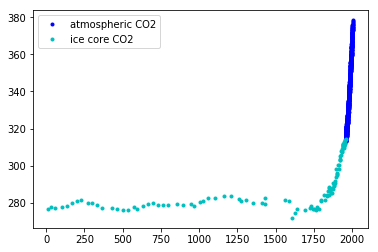

In [44]:
plt.plot(air.year.values, air.CO2.values, ".b", label="atmospheric CO2");
plt.plot(ice.year.values, ice.CO2.values, ".", color="c", label="ice core CO2");
plt.legend();

If we zoom in on the late 1950's, we can see that the atmospheric data has a seasonal component, while the ice core data does not.  

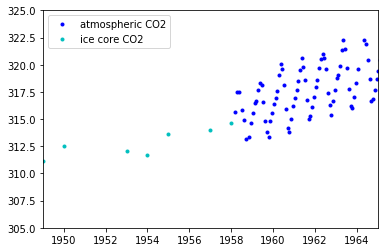

In [45]:
plt.plot(air.year.values, air.CO2.values, ".b", label="atmospheric CO2");
plt.plot(ice.year.values, ice.CO2.values, ".", color="c", label="ice core CO2");
plt.xlim([1949, 1965]);
plt.ylim([305, 325]);
plt.legend();

Since the ice core data isn't measured accurately, it wont be possible to backcast the seasonal component *unless we model uncertainty in x*.

To model both the data together, we will combine the model we've built up using the ice core data, and combine it with elements from the previous notebook on the Mauna Loa data.  From the previous notebook we will additionally include the

- The `Perioidic`, seasonal component
- The `RatQuad` covariance for short range, annual scale variations

Also, since we are using two different data sets, there should be two different `y`-direction uncertainties, one for the ice core data, and one for the atmospheric data.  Do accomplish this, we make a custom `WhiteNoise` covariance function that has two `σ` parameters. 

All custom covariance functions need to have the same three methods defined, `__init__`, `diag`, and `full`.  `full` returns the full covariance, given either `X` or `X` and a different `Xs`.  `diag` returns only the diagonal, and `__init__` saves the input parameters.

In [46]:
class CustomWhiteNoise(pm.gp.cov.Covariance):
    """ Custom White Noise covariance
    - sigma1 is applied to the first n1 points in the data
    - sigma2 is applied to the next n2 points in the data
    
    The total number of data points n = n1 + n2
    """
    def __init__(self, sigma1, sigma2, n1, n2):
        super(CustomWhiteNoise, self).__init__(1, None)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.n1 = n1
        self.n2 = n2

    def diag(self, X):
        d1 = tt.alloc(tt.square(self.sigma1), self.n1)
        d2 = tt.alloc(tt.square(self.sigma2), self.n2)
        return tt.concatenate((d1, d2), 0)

    def full(self, X, Xs=None):
        if Xs is None:
            return tt.diag(self.diag(X))
        else:
            return tt.alloc(0.0, X.shape[0], Xs.shape[0])

Next we need to organize and combine the two data sets.  Remeber that the unit on the x-axis is centuries, not years.

In [47]:
# form dataset, stack t and co2 measurements
t = np.concatenate((ice.year.values, air.year.values), 0)
y = np.concatenate((ice.CO2.values, air.CO2.values), 0)

y_mu, y_sd = np.mean(ice.CO2.values[0:50]), np.std(y)
y_n = (y - y_mu) / y_sd
t_n = t * 0.01

The specification of the model is below.  Since the data set is larger, we find the MAP estimate, instead of doing MCMC.  We also choose our priors for the hyperparameters more carefully.  For the changepoint covariance, we model the post-industrial revolution data with an `ExpQuad` covariance that has the same longer lengthscale as before the industrial revolution.  The idea is that whatever process was at work before, is still there after.  But then we add the product of a `Polynomial(degree=2)` and a `Matern52`.  We fix the lengthscale of the `Matern52` to two.  Since it has only been about two centuries since the industrial revolution, we force the Polynomial component to decay at that time scale.  This forces the uncertainty to rise at this time scale.

In [48]:
with pm.Model() as model:
    ηc = pm.Gamma("ηc", alpha=3, beta=2)
    ℓc = pm.Gamma("ℓc", alpha=10, beta=1)
    
    # changepoint occurs near the year 1800, sometime between 1760, 1840
    x0 = pm.Normal("x0", mu=18, sd=0.1)
    # the change happens gradually
    a = pm.Gamma("a", alpha=3, beta=1)
    # constant offset
    c = pm.HalfNormal("c", sd=2)
    
    # quadratic polynomial scale
    ηq = pm.HalfNormal("ηq", sd=1)
    ℓq = 2.0 # 2 century impact, since we only have 2 C of post IR data 
    
    cov1 = ηc**2 * pm.gp.cov.ExpQuad(1, ℓc)
    cov2 = ηc**2 * pm.gp.cov.ExpQuad(1, ℓc) + \
           ηq**2 * pm.gp.cov.Polynomial(1, x0, 2, c) * pm.gp.cov.Matern52(1, ℓq) # ~2 century impact
        
    # construct changepoint cov
    sc_cov1 = pm.gp.cov.ScaledCov(1, cov1, logistic, (-a, x0))
    sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, logistic, ( a, x0))
    gp_c = pm.gp.Marginal(cov_func=sc_cov1 + sc_cov2)
    
    # short term variation
    ηs = pm.HalfNormal("ηs", sd=3)
    ℓs = pm.Gamma("ℓs", alpha=5, beta=100)
    α = pm.Gamma("α", alpha=4, beta=1)
    cov_s = ηs**2 * pm.gp.cov.RatQuad(1, α, ℓs)
    gp_s = pm.gp.Marginal(cov_func=cov_s)
    
    # medium term variation
    ηm = pm.HalfNormal("ηm", sd=5)
    ℓm = pm.Gamma("ℓm", alpha=2, beta=3)
    cov_m = ηm**2 * pm.gp.cov.ExpQuad(1, ℓm)
    gp_m = pm.gp.Marginal(cov_func=cov_m)
    
    ## periodic
    ηp = pm.HalfNormal("ηp", sd=2)
    ℓp_decay = pm.Gamma("ℓp_decay", alpha=40, beta=0.1)
    ℓp_smooth = pm.Normal("ℓp_smooth ", mu=1.0, sd=0.05)
    period = 1 * 0.01  # we know the period is annual
    cov_p = ηp**2 * pm.gp.cov.Periodic(1, period, ℓp_smooth) \
                  * pm.gp.cov.ExpQuad(1, ℓp_decay)
    gp_p = pm.gp.Marginal(cov_func=cov_p) 
    
    gp = gp_c + gp_m + gp_s + gp_p
    
    # - x location uncertainty (sd = 0.01 is a standard deviation of one year)
    # - only the first 111 points are the ice core data
    # - sd = 0.002 says the point may be the given data +- about half a year
    t_mu = t_n[:111]
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.002, shape=len(t_mu))
    t_uncert = t_mu - t_diff
    t_combined = tt.concatenate((t_uncert, t_n[111:]), 0)
    
    # Noise covariance, using boundary avoiding priors for MAP estimation
    σ1 = pm.Gamma("σ1", alpha=3, beta=50)
    σ2 = pm.Gamma("σ2", alpha=3, beta=50)
    η_noise = pm.HalfNormal("η_noise", sd=1)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=200)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
                CustomWhiteNoise(σ1, σ2, 111, 545)
    
    
    y_ = gp.marginal_likelihood("y", X=t_combined[:,None], y=y_n, noise=cov_noise)

In [49]:
with model:
    mp = pm.find_MAP(method="BFGS")

logp = 2,447.7, ||grad|| = 2.2812: 100%|██████████| 398/398 [03:24<00:00,  1.95it/s] 


Lets look at the results.  First we'll look at the predictions out to the year 2050.

In [60]:
tnew = np.linspace(1700, 2040, 3000) * 0.01
mu, var = gp.predict(tnew[:,None], point=mp, diag=True)

In [61]:
# rescale
mu_s = y_sd * mu + y_mu
sd = np.sqrt(var)*y_sd

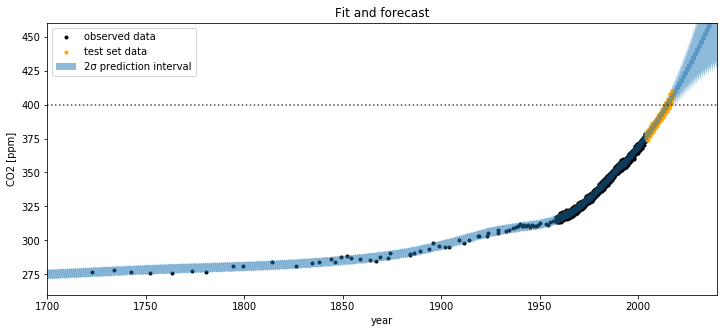

In [62]:
plt.figure(figsize=(12,5))

plt.plot(t, y, 'k.', label="observed data");
plt.plot(air_test.year.values, air_test.CO2.values, ".", color="orange", label="test set data");

plt.plot(100*tnew, mu_s, alpha=0.5);
plt.fill_between(100*tnew, mu_s - 2*sd, mu_s + 2*sd, alpha=0.5, label="2σ prediction interval");
plt.axhline(y=400, color="k", alpha=0.7, linestyle=":")
plt.ylabel("CO2 [ppm]")
plt.xlabel("year");
plt.title("Fit and forecast")
plt.legend();
plt.xlim([1700,2040]);
plt.ylim([260, 460]);

Lets zoom in for a closer look at the uncertainty intervals at the area around when the CO2 levels first cross 400 ppm.

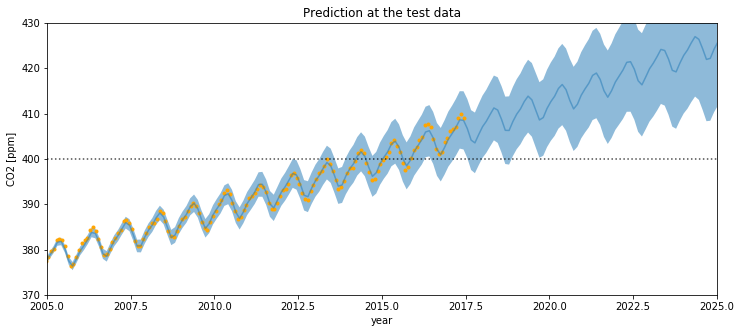

In [63]:
plt.figure(figsize=(12,5))

plt.plot(t, y, 'k.');
plt.plot(100*(t_n[:111] - mp["t_diff"]), y[:111], ".y");
plt.plot(air_test.year.values, air_test.CO2.values, ".", color="orange");

plt.plot(100*tnew, mu_s, alpha=0.5);
plt.fill_between(100*tnew, mu_s - 2*sd, mu_s + 2*sd, alpha=0.5);
plt.axhline(y=400, color="k", alpha=0.7, linestyle=":")
plt.ylabel("CO2 [ppm]")
plt.xlabel("year")
plt.title("Prediction at the test data")
plt.xlim([2005,2025]);
plt.ylim([370, 430]);

If you compare this to the first Mauna Loa example notebook, the predictions are much better.  The date when the CO2 level first hits 400 is predicted more accurately.  This improvement in the bias is due to including the `Polynomial * Matern52` term.  

We can also look at what the model says about CO2 levels back in time.  Since we allowed the `x` measurements to have uncertainty, we are able to fit the seasonal component back in time.  Lets look at the fit of the model 

In [64]:
tnew = np.linspace(11, 32, 500) * 0.01
mu, var = gp.predict(tnew[:,None], point=mp, diag=True)

In [65]:
# rescale
mu_s = y_sd * mu + y_mu
sd = np.sqrt(var)*y_sd

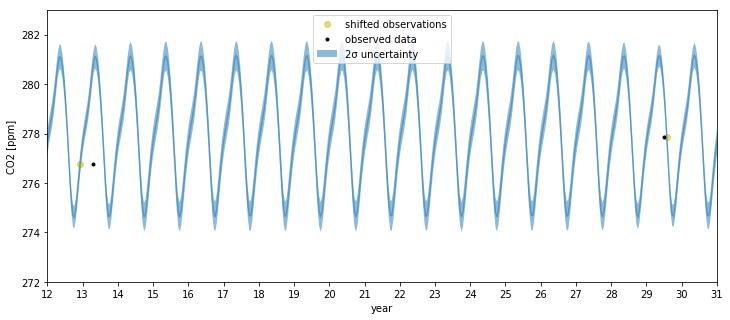

In [66]:
plt.figure(figsize=(12,5))

plt.plot(100*(t_n[:111] - mp["t_diff"]), y[:111], "oy", alpha=0.5, label="shifted observations");
plt.plot(t, y, 'k.', label="observed data");
plt.plot(air_test.year.values, air_test.CO2.values, ".", color="orange");

plt.plot(100*tnew, mu_s, alpha=0.5);
plt.fill_between(100*tnew, mu_s - 2*sd, mu_s + 2*sd, alpha=0.5, label="2σ uncertainty");
plt.legend(loc="upper center");
plt.ylabel("CO2 [ppm]")
plt.xlabel("year")
plt.xlim([12, 31]);
plt.xticks(np.arange(12,32));
plt.ylim([272, 283]);

We can see that far back in time, we can backcast even the seasonal behavior.  The ~half year of uncertainty in the `x` locations allows them to be slightly shifted onto the nearest part of the seasonal oscillation for that year.  The magnitude of the oscillation is the same as it is now.

In [67]:
tnew = np.linspace(-20, 0, 300) * 0.01
mu, var = gp.predict(tnew[:,None], point=mp, diag=True)

In [68]:
# rescale
mu_s = y_sd * mu + y_mu
sd = np.sqrt(var)*y_sd

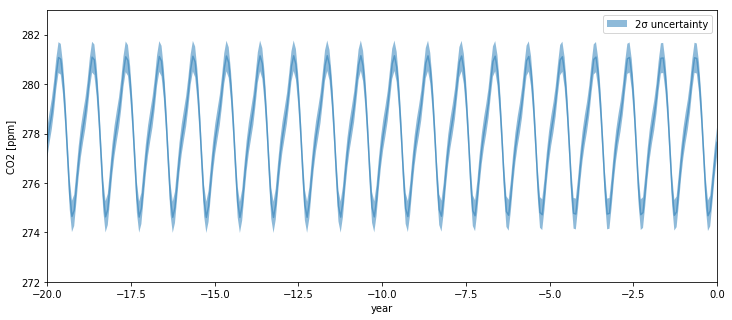

In [69]:
plt.figure(figsize=(12,5))

plt.plot(100*tnew, mu_s, alpha=0.5);
plt.fill_between(100*tnew, mu_s - 2*sd, mu_s + 2*sd, alpha=0.5, label="2σ uncertainty");
plt.legend();
plt.ylabel("CO2 [ppm]")
plt.xlabel("year")
plt.xlim([-20, 0]);
plt.ylim([272, 283]);

As we go back before the year zero BCE, the backcasted seasonality remains intact, as I would expect.